In [1]:
import sys
sys.path.append('..')
from cmost_exposure import load_by_filepath, scan_headers

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

cmost_dir = '../data'

In [2]:
# Load a small subset of HDR expsoures
all_files = scan_headers(cmost_dir+'/030921')

subset = (all_files['READOUTM'] == 'ROLLINGRESET_HDR') & (all_files['LED'] == 1.64)
files = all_files[subset]
files.sort('DATE')

files.pprint_all()

exposures = load_by_filepath(files['FILEPATH'],cleanup=False)

                   FILEPATH                        READOUTM                DATE            EXPTIME LED    TEMP  CAMERAID      DETID      GAIN
---------------------------------------------- ---------------- -------------------------- ------- ---- ------- -------- --------------- ----
../data/030921/cmostjpl005_20210310024754.fits ROLLINGRESET_HDR 2021-03-10 02:48:09.506432  3630.0 1.64   140.0 cmostjpl EuropaBSI-1-7-3  hdr
../data/030921/cmostjpl005_20210310024809.fits ROLLINGRESET_HDR 2021-03-10 02:48:30.698183  6918.0 1.64   140.0 cmostjpl EuropaBSI-1-7-3  hdr
../data/030921/cmostjpl005_20210310024830.fits ROLLINGRESET_HDR 2021-03-10 02:49:07.114988 13182.0 1.64   140.0 cmostjpl EuropaBSI-1-7-3  hdr
../data/030921/cmostjpl005_20210310024907.fits ROLLINGRESET_HDR 2021-03-10 02:50:14.572777 25118.0 1.64 140.001 cmostjpl EuropaBSI-1-7-3  hdr


In [7]:
print(exposures[0].get_info())

 Properties: 
		Readout mode: ROLLINGRESET_HDR 
		Date: 2021-03-10T02:48:09.506432 
		Exposure time: 3630.0 ms
		LED voltage: 1.64 V 
		Temperature: 140.0 K
		Camera ID: cmostjpl 
		Detector ID: EuropaBSI-1-7-3
		Gain mode: hdr
		Number of frames: 2 x 2 frames
		
		


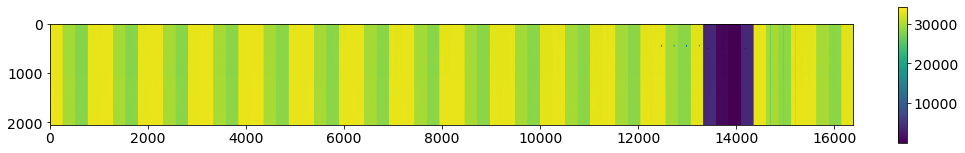

In [3]:
# Plot the raw image
# Four columns per amplifier: (1) Reset Low, (2) Reset High, (3) Signal High, (4) Signal Low
plt.figure(figsize=[16,5])
plt.imshow(exposures[0].raw_frames[1])
plt.colorbar(fraction=0.05, aspect=15, shrink=0.5)
plt.savefig('plots/20210310_raw_image.pdf')
plt.show()
plt.close()

For the HDR mode, the cds_frames attribute will be a 4-d array rather than 3-d. The first dimension is the number of exposures taken for this image file, the second dimension is size 2 with high gain data followed by low gain data. The other two dimensions are the image dimensions. So the array basically looks like this, with high and low gain frames in pairs for each exposure:

\[ \[ Frame 1 High Gain, Frame 1 Low Gain \],\
&nbsp;&nbsp;\[ Frame 2 High Gain, Frame 2 Low Gain \] ... \] 

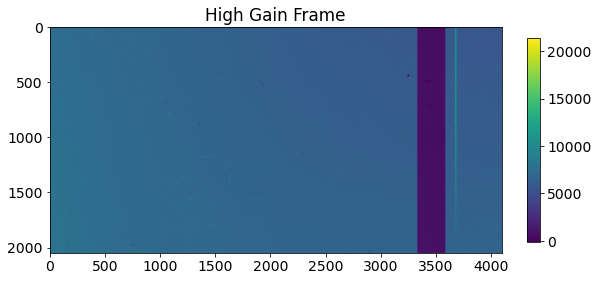

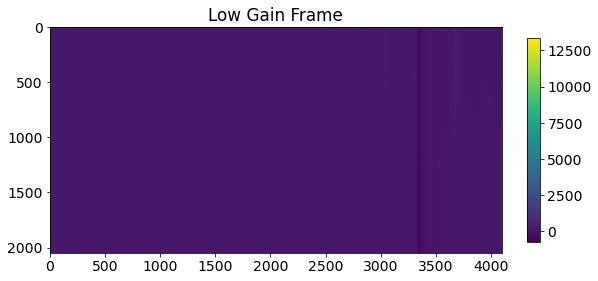

In [10]:
cds_high_frame, cds_low_frame = exposures[3].cds_frames[0,0], exposures[0].cds_frames[0,1]

plt.figure(figsize=[9,5])
plt.title('High Gain Frame')
plt.imshow(cds_high_frame)
plt.colorbar(fraction=0.05, aspect=15, shrink=0.75)
plt.show()
plt.close()

plt.figure(figsize=[9,5])
plt.title('Low Gain Frame')
plt.imshow(cds_low_frame)
plt.colorbar(fraction=0.05, aspect=15, shrink=0.75)
plt.show()
plt.close()

For the HDR mode, statistical functions such as get_median() will return an array of the form \[high gain median, low gain median\] etc.

In [5]:
# Define a subframe (region of interest) in the format (x1, x2, y1, y2)
subframe = (2600,2700,200,300)

# Populate arrays for fitting/plotting
n_exp = len(exposures)
exp_times, median, var = np.zeros(n_exp), np.zeros((n_exp,2)), np.zeros((n_exp,2))
for i in range(n_exp):
    exp_times[i] = exposures[i].exp_time
    median[i] = exposures[i].get_median(subframe)
    var[i] = exposures[i].get_variance(subframe)

print("High Gain & Low Gain median for {} exposures".format(n_exp))
print(median)

High Gain & Low Gain median for 4 exposures
[[1259.  140.]
 [1983.  220.]
 [3380.  374.]
 [6095.  674.]]


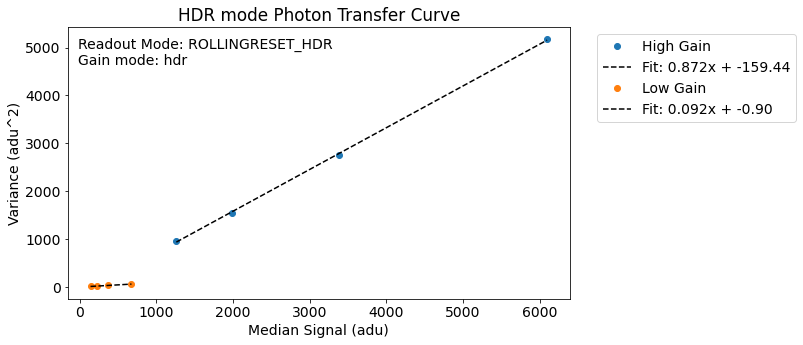

In [12]:
# Plot the photon transfer curve
plt.figure(figsize=[9,5])
plt.title('HDR mode Photon Transfer Curve')
    
# Linear fit for high and low gain PTCs
for i, label in enumerate(['High Gain','Low Gain']):
    signal, variance = median[:,i], var[:,i]
    
    plt.plot(signal,variance,'o',label=label)
    
    m, b = np.polyfit(signal, variance, 1)
    poly1d_fn = np.poly1d([m, b]) 
    
    plt.plot(signal,poly1d_fn(signal),'--k',label='Fit: {:.3f}x + {:.2f}'.format(m, b))

plt.xlabel('Median Signal (adu)')
plt.ylabel('Variance (adu^2)')

# Plot information
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
info = 'Readout Mode: {}\nGain mode: {}'.format(exposures[0].readout_mode,exposures[0].gain)
plt.annotate(info, xy=(0.02, 0.86), xycoords='axes fraction')

plt.savefig('plots/20210310_HDR_PTC.pdf')
plt.show()
plt.close()